In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib
from mpl_finance import candlestick2_ohlc, candlestick_ohlc
import matplotlib.dates as mdates
%matplotlib inline

In [3]:
codeList = ['A005930', 'A000660', 'A068270', 'A207940', 'A005380', 'A005490',\
            'A051910', 'A035420', 'A028260', 'A012330', 'A017670', 'A105560',\
            'A055550', 'A015760', 'A051900', 'A018260', 'A034730', 'A032830',\
            'A096770', 'A006400', 'A145020', 'A051370', 'A037460', 'A088800']
stName = ['삼성전자', 'SK하이닉스', '셀트리온', '삼성바이오로직스', '현대차', 'POSCO',\
          'LG화학', 'NAVER', '삼성물산', '현대모비스', 'SK텔레콤', 'KB금융', \
          '신한지주', '한국전력', 'LG생활건강', '삼성에스디에스', 'SK', '삼성생명',\
          'SK이노베이션', '삼성SDI', '휴젤', '인터플렉스', '삼지전자', '에이스테크']
Name2Code = {nm:code for nm, code in zip(stName, codeList)}
print(Name2Code)

{'NAVER': 'A035420', '현대모비스': 'A012330', '신한지주': 'A055550', 'SK': 'A034730', 'SK이노베이션': 'A096770', '삼성바이오로직스': 'A207940', '삼성SDI': 'A006400', 'LG화학': 'A051910', '인터플렉스': 'A051370', 'LG생활건강': 'A051900', '삼성에스디에스': 'A018260', 'SK하이닉스': 'A000660', '셀트리온': 'A068270', '삼성생명': 'A032830', 'POSCO': 'A005490', 'KB금융': 'A105560', '삼성물산': 'A028260', '휴젤': 'A145020', '에이스테크': 'A088800', '한국전력': 'A015760', 'SK텔레콤': 'A017670', '현대차': 'A005380', '삼지전자': 'A037460', '삼성전자': 'A005930'}


# ■ Data 불러오기
- HDF5 파일형식의 DB에서 pandas의 read_hdf 함수로 데이터를 불러옵니다.
    [HDF5 file format](https://datascienceschool.net/view-notebook/f1c286a1d5164975a9909bb7a341bf4c/)
- Data는 위 Cell에 언급된 시총 상위 20종목 이외에 임의로 정한 4종목, 총 24종목의 Daily Data입니다.
- key는 각 종목의 short code로 아래 Cell과 같이 적어줍니다.

In [8]:
close = pd.read_hdf('./daily_stock_price.h5', Name2Code["삼성전자"])
close.head(5)

date   open   high    low  close       vol      marketValue
date                                                                       
2016-08-22  20160822  33480  33840  33180  33300  12612200  235878885000000
2016-08-23  20160823  33300  33880  33140  33740  11545700  238995603000000
2016-08-24  20160824  33600  33640  32720  33060  15938550  234178857000000
2016-08-25  20160825  32600  33180  32440  32780  14173800  232195491000000
2016-08-26  20160826  32120  32460  32060  32240  12058000  228370428000000

In [9]:
def cal_momentum(close, lag=6):
    '''
    close : pd.Series
    '''
    moments = pd.Series(np.ones_like(close), index=close.index)
    for i in range(lag):
        moments *= (close.pct_change(i) + 1)
    return moments

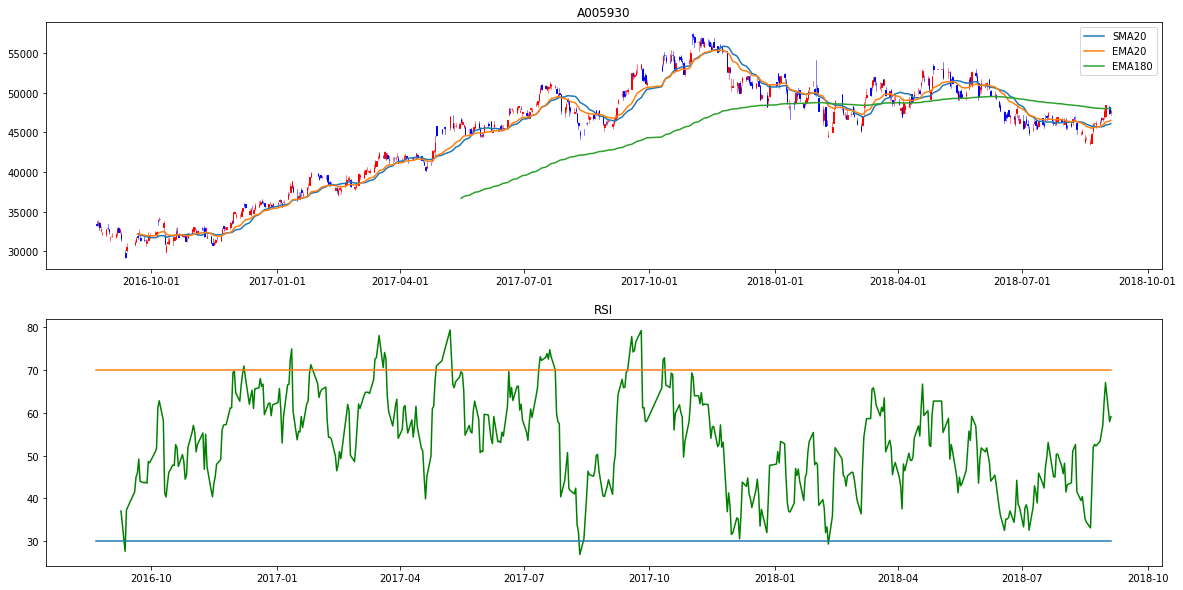

In [10]:
f1, (ax, ax1) = plt.subplots(2,1,figsize = (20,10))
ax.set_title(Name2Code["삼성전자"])

# talib package를 이용한 EMA / RSI / Boleanger Band구하기
# talib의 각 함수는 float형태의 Data를 입력해 주어야 함.
close_ = close['close'].apply(lambda x : float(x)).values
close['EMA'] = talib.EMA(close_, timeperiod=20)
close['EMA180'] = talib.EMA(close_, timeperiod=180)
close['RSI'] = talib.RSI(close_, timeperiod=14)
# upper, middle, lower = talib.BBANDS(close_, matype=talib.MA_Type.T3)

# candlestick_ohlc 함수를 이용하여, 시고저종 캔들차트 그리기
close['date'] = close.index.map(mdates.date2num) # 그래프의 x축에 일자를 표시하기 위해 data 형태 변경
candlestick_ohlc(ax, close.loc[:, ['date', 'open','high','low','close']].values, colorup='red',colordown='blue', width=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.plot(close.index, close['close'].rolling(20).mean(), label="SMA20")
ax.plot(close.index, close['EMA'], label="EMA20")
ax.plot(close.index, close['EMA180'], label="EMA180")
# ax.plot(close.index, upper)
# ax.plot(close.index, middle)
# ax.plot(close.index, lower)
ax.legend()

ax1.plot(close.index, close['RSI'], label = 'RSI', color='g')
ax1.set_title("RSI")
ax1.plot(close.index, 30 * np.ones_like(close['RSI']))
ax1.plot(close.index, 70 * np.ones_like(close['RSI']))
plt.show()

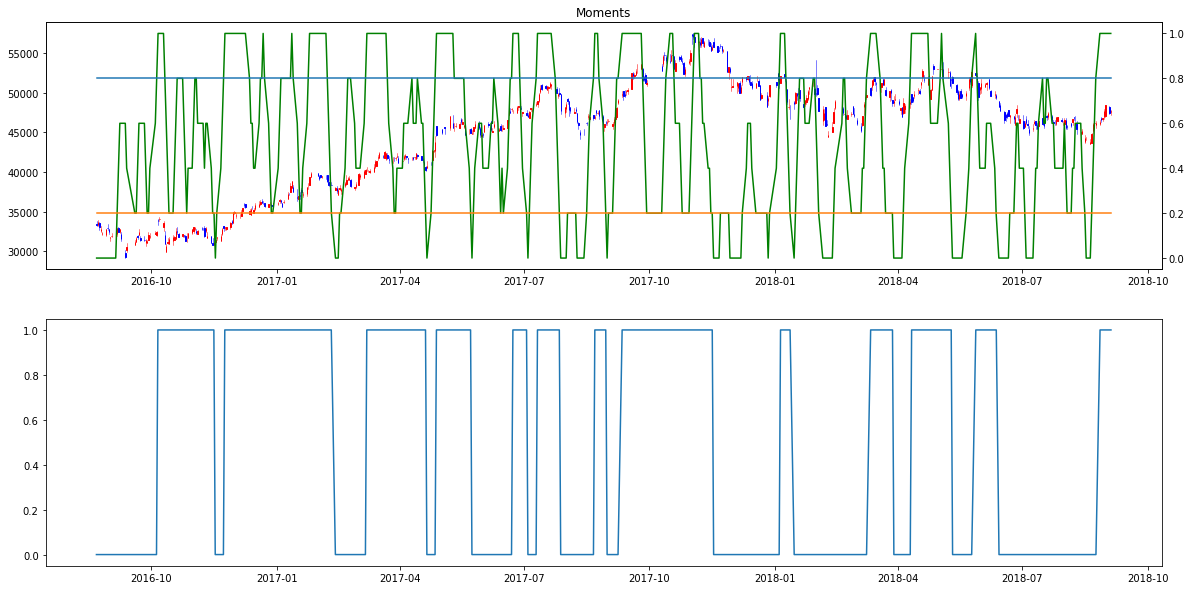

In [26]:
f1, (ax, ax2) = plt.subplots(2,1,figsize = (20,10))

close['date'] = close.index.map(mdates.date2num)
candlestick_ohlc(ax, close.loc[:, ['date', 'open','high','low','close']].values, colorup='red',colordown='blue', width=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Moments Index 구하기
moment = cal_momentum(close['close'])
moment[moment <= 1] = 0
moment[moment > 1] = 1
moment_ma = moment.rolling(5).mean().fillna(method='bfill')

ax1 = ax.twinx()
ax1.plot(moment.index, moment_ma, label = 'moment_idx', color='g')
ax1.plot(moment.index, 0.8 * np.ones_like(moment), label = 'moment_upper_thd')
ax1.plot(moment.index, 0.2 * np.ones_like(moment), label = 'moment_lower_thd')
ax1.set_title("Moments")

prev_sig = 0
moment_idx = pd.Series(np.ones_like(moment), index=moment.index)
bid = False
ask = True

for idx, sig in enumerate(moment_ma.values):
    if ask and sig > 0.8 and prev_sig <= 0.8:
        bid = True
        ask = False
    
    if bid and sig < 0.2 and prev_sig >= 0.2:
        bid = False
        ask = True
    
    if ask:
        moment_idx[idx] = 0

    prev_sig = sig

ax2.plot(moment.index, moment_idx.values)
plt.show()

In [27]:
# close = pd.read_hdf('./daily_price_sample.h5', Name2Code['NAVER'])
close = pd.read_hdf('./daily_stock_price.h5', Name2Code['NAVER'])
close.head(5)

date    open    high     low   close    vol     marketValue
date                                                                       
2016-08-22  20160822  800000  803000  793000  795000  80005  26204790000000
2016-08-23  20160823  801000  808000  795000  806000  69435  26567372000000
2016-08-24  20160824  807000  814000  800000  812000  71904  26765144000000
2016-08-25  20160825  812000  812000  802000  804000  96952  26501448000000
2016-08-26  20160826  796000  809000  796000  805000  75008  26534410000000

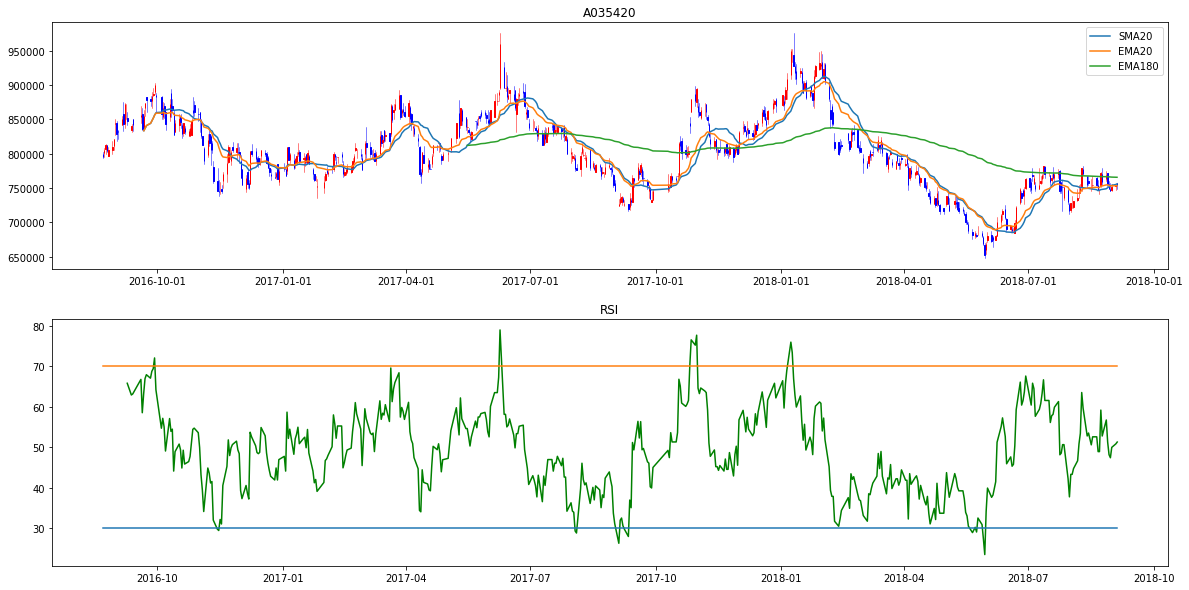

In [28]:
f1, (ax, ax1) = plt.subplots(2,1,figsize = (20,10))
ax.set_title(Name2Code["NAVER"])

# talib package를 이용한 EMA / RSI / Boleanger Band구하기
# talib의 각 함수는 float형태의 Data를 입력해 주어야 함.
close_ = close['close'].apply(lambda x : float(x)).values
close['EMA'] = talib.EMA(close_, timeperiod=20)
close['EMA180'] = talib.EMA(close_, timeperiod=180)
close['RSI'] = talib.RSI(close_, timeperiod=14)
upper, middle, lower = talib.BBANDS(close_, matype=talib.MA_Type.T3)

# candlestick_ohlc 함수를 이용하여, 시고저종 캔들차트 그리기
close['date'] = close.index.map(mdates.date2num) # 그래프의 x축에 일자를 표시하기 위해 data 형태 변경
candlestick_ohlc(ax, close.loc[:, ['date', 'open','high','low','close']].values, colorup='red',colordown='blue', width=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.plot(close.index, close['close'].rolling(20).mean(), label="SMA20")
ax.plot(close.index, close['EMA'], label="EMA20")
ax.plot(close.index, close['EMA180'], label="EMA180")
# ax.plot(close.index, upper)
# ax.plot(close.index, middle)
# ax.plot(close.index, lower)
ax.legend()

ax1.plot(close.index, close['RSI'], label = 'RSI', color='g')
ax1.set_title("RSI")
ax1.plot(close.index, 30 * np.ones_like(close['RSI']))
ax1.plot(close.index, 70 * np.ones_like(close['RSI']))
plt.show()

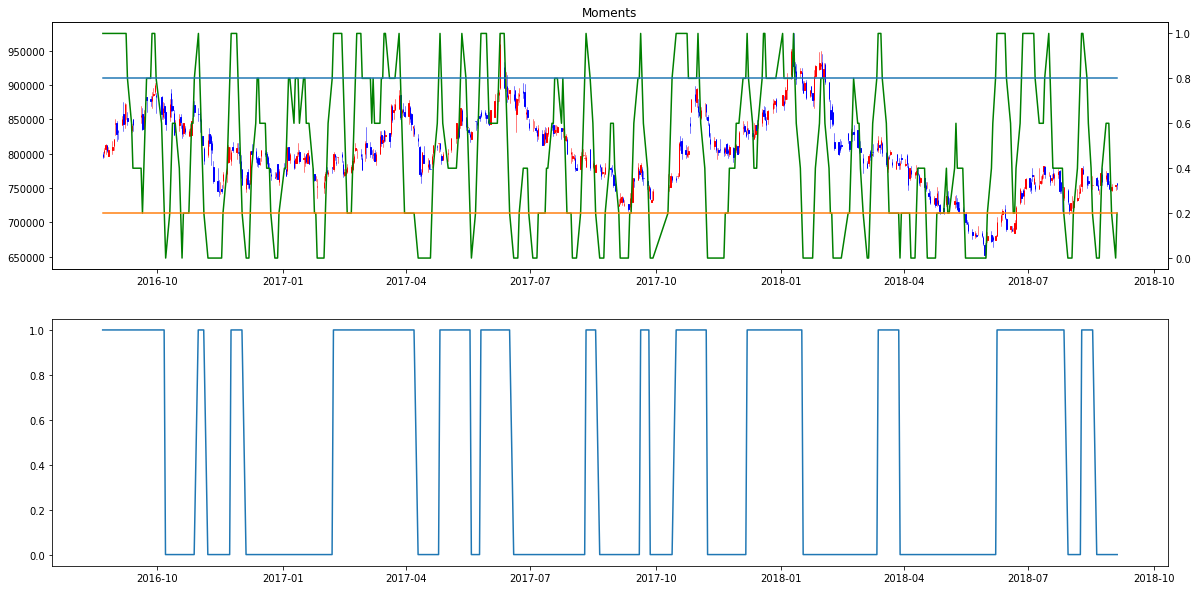

In [29]:
f1, (ax, ax2) = plt.subplots(2,1,figsize = (20,10))

close['date'] = close.index.map(mdates.date2num)
candlestick_ohlc(ax, close.loc[:, ['date', 'open','high','low','close']].values, colorup='red',colordown='blue', width=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Moments Index 구하기
moment = cal_momentum(close['close'])
moment[moment <= 1] = 0
moment[moment > 1] = 1
moment_ma = moment.rolling(5).mean().fillna(method='bfill')

ax1 = ax.twinx()
ax1.plot(moment.index, moment_ma, label = 'moment_idx', color='g')
ax1.plot(moment.index, 0.8 * np.ones_like(moment), label = 'moment_upper_thd')
ax1.plot(moment.index, 0.2 * np.ones_like(moment), label = 'moment_lower_thd')
ax1.set_title("Moments")

prev_sig = 0
moment_idx = pd.Series(np.ones_like(moment), index=moment.index)
bid = False
ask = True

for idx, sig in enumerate(moment_ma.values):
    if ask and sig > 0.8 and prev_sig <= 0.8:
        bid = True
        ask = False
    
    if bid and sig < 0.2 and prev_sig >= 0.2:
        bid = False
        ask = True
    
    if ask:
        moment_idx[idx] = 0

    prev_sig = sig

ax2.plot(moment.index, moment_idx.values)
plt.show()

In [30]:
# close = pd.read_hdf('./daily_price_sample.h5', Name2Code['인터플렉스'])
close = pd.read_hdf('./daily_stock_price.h5', Name2Code['인터플렉스'])

close.head(5)

date   open   high    low  close     vol   marketValue
date                                                                  
2016-08-22  20160822  20300  20900  19350  20500  399805  335790000000
2016-08-23  20160823  20500  20650  19400  19800  237642  324324000000
2016-08-24  20160824  19900  20100  19200  19500  214600  319410000000
2016-08-25  20160825  19600  19950  18350  18450  303416  302211000000
2016-08-26  20160826  18500  19400  18250  19100  315927  312858000000

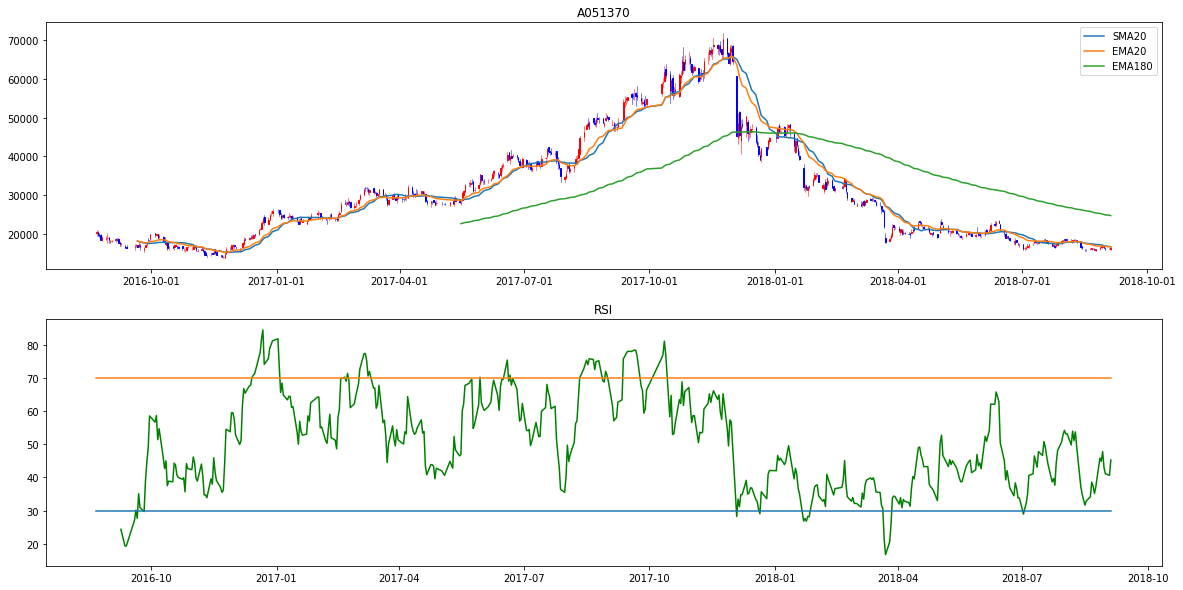

In [35]:
f1, (ax, ax1) = plt.subplots(2,1,figsize = (20,10))
ax.set_title(Name2Code["인터플렉스"])

close['EMA'] = talib.EMA(close['close'].apply(lambda x : float(x)).values, timeperiod=20)
close['EMA180'] = talib.EMA(close['close'].apply(lambda x : float(x)).values, timeperiod=180)
close['RSI'] = talib.RSI(close['close'].apply(lambda x : float(x)).values, timeperiod=14)

close['date'] = close.index.map(mdates.date2num)
candlestick_ohlc(ax, close.loc[:, ['date', 'open','high','low','close']].values, colorup='red',colordown='blue', width=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.plot(close.index, close['close'].rolling(20).mean(), label="SMA20")
ax.plot(close.index, close['EMA'], label="EMA20")
ax.plot(close.index, close['EMA180'], label="EMA180")
ax.legend()

ax1.plot(close.index, close['RSI'], label = 'RSI', color='g')
ax1.set_title("RSI")
ax1.plot(close.index, 30 * np.ones_like(close['RSI']))
ax1.plot(close.index, 70 * np.ones_like(close['RSI']))
plt.show()

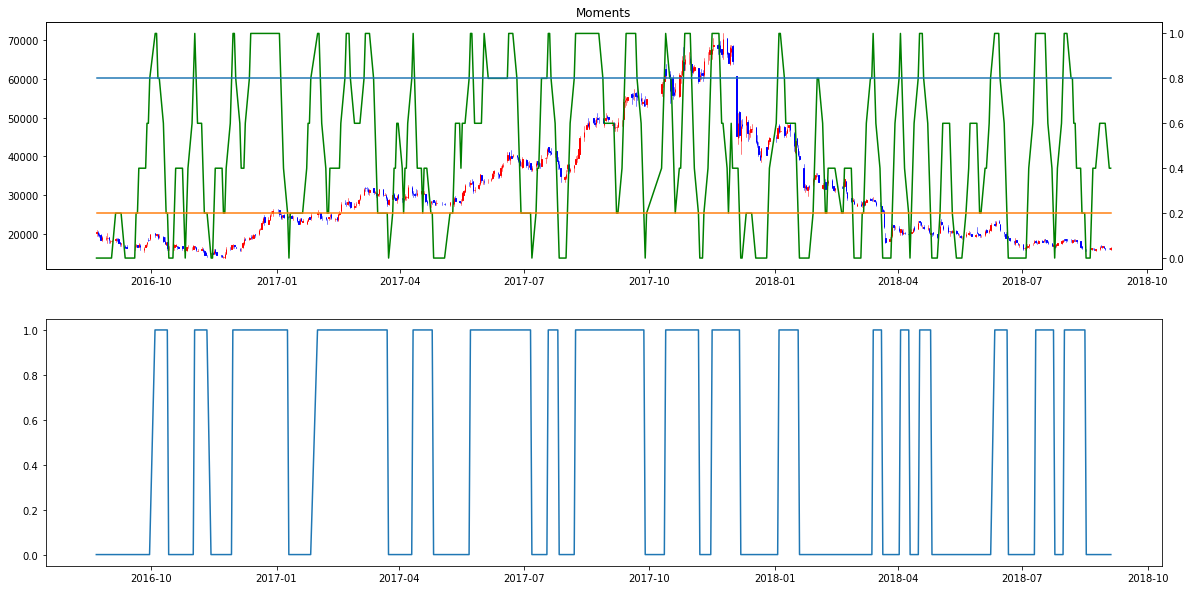

In [32]:
f1, (ax, ax2) = plt.subplots(2,1,figsize = (20,10))

close['date'] = close.index.map(mdates.date2num)
candlestick_ohlc(ax, close.loc[:, ['date', 'open','high','low','close']].values, colorup='red',colordown='blue', width=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Moments Index 구하기
moment = cal_momentum(close['close'])
moment[moment <= 1] = 0
moment[moment > 1] = 1
moment_ma = moment.rolling(5).mean().fillna(method='bfill')

ax1 = ax.twinx()
ax1.plot(moment.index, moment_ma, label = 'moment_idx', color='g')
ax1.plot(moment.index, 0.8 * np.ones_like(moment), label = 'moment_upper_thd')
ax1.plot(moment.index, 0.2 * np.ones_like(moment), label = 'moment_lower_thd')
ax1.set_title("Moments")

prev_sig = 0
moment_idx = pd.Series(np.ones_like(moment), index=moment.index)
bid = False
ask = True

for idx, sig in enumerate(moment_ma.values):
    if ask and sig > 0.8 and prev_sig <= 0.8:
        bid = True
        ask = False
    
    if bid and sig < 0.2 and prev_sig >= 0.2:
        bid = False
        ask = True
    
    if ask:
        moment_idx[idx] = 0

    prev_sig = sig

ax2.plot(moment.index, moment_idx.values)
plt.show()

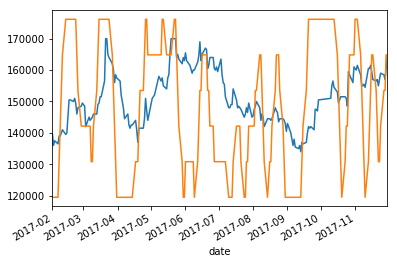

In [25]:
moment = cal_momentum(close['close'])
close['close'].loc["2017-02-01":"2017-11-30"].plot()
moment[moment <= 1] = 0
moment[moment > 1] = 1
(moment.rolling(5).mean()).loc["2017-02-01":"2017-11-30"].plot()

In [39]:
def simulation(klines, lag=20, is_inv=True):
    cummax = klines[0:lag].max()
    bid_price = klines[lag]
    close_done = True
    bid_done = False
    fee = pd.Series(np.ones_like(klines), index=klines.index)
    portions = pd.Series(np.ones_like(klines), index=klines.index)
    cummaxs = pd.Series(np.ones_like(klines), index=klines.index)
    profit = klines
    portion = 1
    is_capture = pd.Series(False, index=klines.index)
    n_trade = 0

    plt.figure()
    klines.plot()
    plt.ion()

    for idx, price in enumerate(klines.values[lag:]):
        max_lag = klines[idx : idx + lag].max()
        min_lag = klines[idx : idx + lag].min()
        
        if is_inv:
            bid = max_lag < price
        else:
            bid = min_lag > price
            
        if bid and close_done:
            bid_price = price
            profit[idx] = bid_price
            cummax = bid_price
            bid_done = True
            close_done = False
            plt.scatter(klines.index[idx+lag], bid_price, color='r')

        cummax = np.maximum(cummax, price)
        cummaxs[idx] = cummax

        if is_inv:
            ask = min_lag > price
        else:
            ask = max_lag < price
            
        if bid_done and ask:
            ask_price = price
            fee[idx] *= (1 - 0.0025)

            close_done = True
            bid_done = False
            plt.scatter(klines.index[idx+lag], ask_price, color='c')
            n_trade += 1

        if bid_done and ~close_done and idx == klines.values.shape[0] - 1:
            ask_price = price
            fee[idx] *= (1 - 0.0025)

            close_done = True
            bid_done = False
            plt.scatter(klines.index[idx], ask_price, color='c')
            n_trade += 1

        if bid_done and ~close_done:
            is_capture[idx] = True

    cummaxs.shift(lag).plot()
    print("Total number of trade : %d" % (n_trade))
    return profit, portions, fee, is_capture

In [4]:
close = pd.read_hdf('./daily_price_sample.h5', Name2Code['인터플렉스'])
close.head(5)

date   open   high    low  close     vol   marketValue
date                                                                  
2016-08-22  20160822  20300  20900  19350  20500  399805  335790000000
2016-08-23  20160823  20500  20650  19400  19800  237642  324324000000
2016-08-24  20160824  19900  20100  19200  19500  214600  319410000000
2016-08-25  20160825  19600  19950  18350  18450  303416  302211000000
2016-08-26  20160826  18500  19400  18250  19100  315927  312858000000

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Total number of trade : 5
Total Profit : 2.4169 / MDD : -0.2903


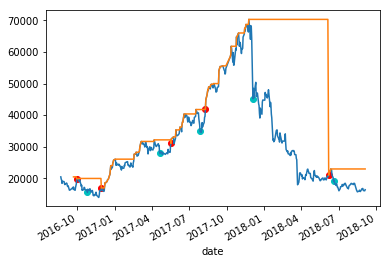

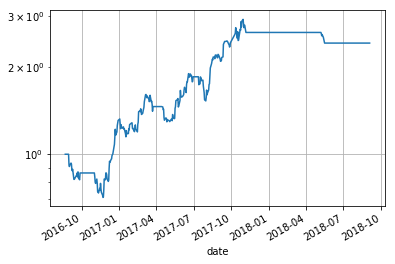

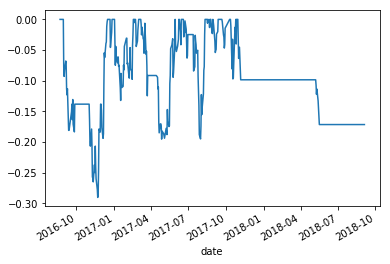

In [38]:
profit, portions, fee, is_capture = simulation(close['close'], lag=20)

prf = (profit.pct_change(1) + 1)
is_cap_ = is_capture.shift(1).fillna(False)
# print(is_capture)
prf *= fee.shift(1)

plt.figure("profit")
prf[~is_cap_] = 1
prf_cap = prf.cumprod()
prf_cap.plot(logy=True)
plt.grid()

plt.figure("mdd")
mdd = (prf_cap - prf_cap.cummax()) / prf_cap.cummax()
mdd.plot()
print("Total Profit : {0:0.4f} / MDD : {1:0.4f}".format(prf_cap[-1], mdd.min()))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Total number of trade : 5
Total Profit : 0.5825 / MDD : -0.7499


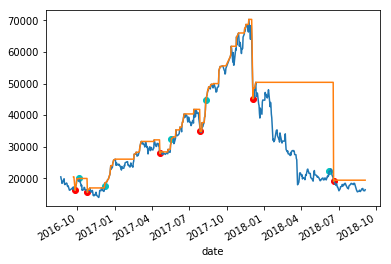

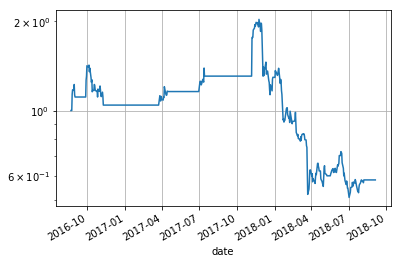

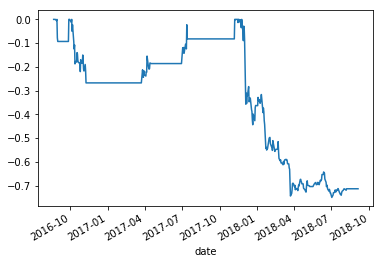

In [40]:
profit, portions, fee, is_capture = simulation(close['close'], lag=20, is_inv=False)

prf = (profit.pct_change(1) + 1)
is_cap_ = is_capture.shift(1).fillna(False)
# print(is_capture)
prf *= fee.shift(1)

plt.figure("profit")
prf[~is_cap_] = 1
prf_cap = prf.cumprod()
prf_cap.plot(logy=True)
plt.grid()

plt.figure("mdd")
mdd = (prf_cap - prf_cap.cummax()) / prf_cap.cummax()
mdd.plot()
print("Total Profit : {0:0.4f} / MDD : {1:0.4f}".format(prf_cap[-1], mdd.min()))